In [1]:
import sys
import os
#homedir = os.path.dirname(os.path.abspath(__file__))
homedir = os.path.abspath('')
sys.path.append(os.path.dirname(os.path.dirname(homedir)))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from torch_lr_finder import LRFinder


SEED = 1
use_cuda = torch.cuda.is_available()
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)
device = torch.device("cuda" if use_cuda else "cpu")

/home/raghu/.local/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from custom_resnet import customResNet
from utils import *
from train_loop import train, test, get_optim, get_schedulder

In [4]:
custom_resnet = customResNet().to(device)


In [5]:
model_copy = copy.deepcopy(custom_resnet)
model_copy.to(device)

customResNet(
  (prep_blk): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (X1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (R1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [6]:
cifar10_trainloader_ocp, cifar10_testloader_ocp = get_augmented_cifar10_dataset("/home/raghu/work/data/", train_tfms=default_test_transforms, test_tfms=default_test_transforms, batch_sz=512, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.43E-03


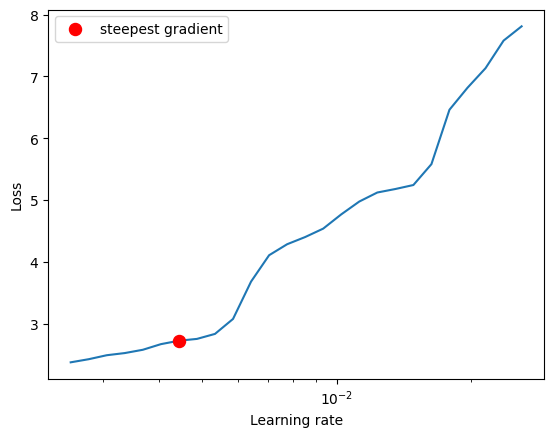

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.004430621457583881)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer_ocp = optim.Adam(model_copy.parameters(), lr=1e-3)
lr_finder = LRFinder(model_copy, optimizer_ocp, criterion, device=device)
lr_finder.range_test(cifar10_trainloader_ocp, val_loader=cifar10_testloader_ocp, end_lr=10, num_iter=100)
lr_finder.plot()

In [11]:
cifar10_trainloader, cifar10_testloader = get_augmented_cifar10_dataset("/home/raghu/work/data/", train_tfms=default_train_transforms, test_tfms=default_test_transforms, batch_sz=512)
optimizer = torch.optim.Adam(custom_resnet.parameters(), lr = 4.43e-3)    #SGD(custom_resnet.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(cifar10_trainloader), epochs=24, pct_start=0.2, div_factor=10, three_phase=False, final_div_factor=50,anneal_strategy='linear')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
EPOCHS = 24

train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(custom_resnet, device, cifar10_trainloader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test(custom_resnet, device, cifar10_testloader, test_losses, test_acc)

EPOCH: 0


Loss=1.205458402633667 Batch_id=97 Accuracy=43.59: 100%|██████████| 98/98 [00:04<00:00, 23.78it/s] 



Test set: Average loss: 3.3341, Accuracy: 1012/10000 (10.12%)

EPOCH: 1


Loss=1.0656003952026367 Batch_id=97 Accuracy=59.30: 100%|██████████| 98/98 [00:03<00:00, 25.20it/s]



Test set: Average loss: 3.4584, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=0.8697162866592407 Batch_id=97 Accuracy=66.71: 100%|██████████| 98/98 [00:03<00:00, 25.14it/s]



Test set: Average loss: 3.2076, Accuracy: 1002/10000 (10.02%)

EPOCH: 3


Loss=0.8243365287780762 Batch_id=97 Accuracy=71.05: 100%|██████████| 98/98 [00:03<00:00, 25.16it/s]



Test set: Average loss: 4.1504, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Loss=0.6539953351020813 Batch_id=97 Accuracy=74.53: 100%|██████████| 98/98 [00:03<00:00, 25.14it/s]



Test set: Average loss: 3.8474, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Loss=0.677672803401947 Batch_id=97 Accuracy=76.89: 100%|██████████| 98/98 [00:03<00:00, 25.13it/s] 



Test set: Average loss: 4.0528, Accuracy: 1000/10000 (10.00%)

EPOCH: 6


Loss=0.5401902198791504 Batch_id=97 Accuracy=79.33: 100%|██████████| 98/98 [00:03<00:00, 25.25it/s]



Test set: Average loss: 3.8250, Accuracy: 1000/10000 (10.00%)

EPOCH: 7


Loss=0.5606231689453125 Batch_id=97 Accuracy=80.80: 100%|██████████| 98/98 [00:03<00:00, 25.20it/s] 



Test set: Average loss: 4.0427, Accuracy: 1000/10000 (10.00%)

EPOCH: 8


Loss=0.5186077356338501 Batch_id=97 Accuracy=82.43: 100%|██████████| 98/98 [00:03<00:00, 25.29it/s] 



Test set: Average loss: 3.6145, Accuracy: 1000/10000 (10.00%)

EPOCH: 9


Loss=0.5067850947380066 Batch_id=97 Accuracy=83.69: 100%|██████████| 98/98 [00:03<00:00, 25.11it/s] 



Test set: Average loss: 3.2806, Accuracy: 1000/10000 (10.00%)

EPOCH: 10


Loss=0.4894150197505951 Batch_id=97 Accuracy=84.72: 100%|██████████| 98/98 [00:03<00:00, 25.17it/s] 



Test set: Average loss: 3.7939, Accuracy: 1000/10000 (10.00%)

EPOCH: 11


Loss=0.42111438512802124 Batch_id=97 Accuracy=85.65: 100%|██████████| 98/98 [00:03<00:00, 25.20it/s]



Test set: Average loss: 3.9659, Accuracy: 1000/10000 (10.00%)

EPOCH: 12


Loss=0.393052339553833 Batch_id=97 Accuracy=86.90: 100%|██████████| 98/98 [00:03<00:00, 25.18it/s]  



Test set: Average loss: 3.6439, Accuracy: 1000/10000 (10.00%)

EPOCH: 13


Loss=0.3898353576660156 Batch_id=97 Accuracy=87.35: 100%|██████████| 98/98 [00:03<00:00, 25.23it/s] 



Test set: Average loss: 4.1213, Accuracy: 1000/10000 (10.00%)

EPOCH: 14


Loss=0.3466624617576599 Batch_id=97 Accuracy=88.42: 100%|██████████| 98/98 [00:03<00:00, 25.12it/s] 



Test set: Average loss: 4.1630, Accuracy: 1000/10000 (10.00%)

EPOCH: 15


Loss=0.30370575189590454 Batch_id=97 Accuracy=88.84: 100%|██████████| 98/98 [00:03<00:00, 25.12it/s]



Test set: Average loss: 3.7528, Accuracy: 1000/10000 (10.00%)

EPOCH: 16


Loss=0.3301960527896881 Batch_id=22 Accuracy=89.82:  22%|██▏       | 22/98 [00:00<00:02, 25.43it/s] 